In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import gsw

from scipy.interpolate import griddata
from salishsea_tools import unit_conversions
from salishsea_tools import psu_tools
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point

IOPATH = '/ocean/ghoeven/MOAD/Data/PNW_obs_compiled.csv'

In [3]:
ds = xr.open_dataset("/ocean/ghoeven/MOAD/Data/gebco_2023.nc")

In [4]:
obs = pd.read_csv(IOPATH)
obs['current'] = np.nan

grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

In [5]:
# Salish Sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [6]:
# 500m Depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)



In [7]:
# Lat and lon cuttoff
xlim, ylim = [-145.5, -120.2], [30, 60]

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [8]:
# Remove Washington Dept of Ecology and ONC data as they consist of river and salish sea data (not offshore so not relevant)
ind = np.where(obs['source'] == 'department of ecology') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)
ind = np.where(obs['source'] == 'onc') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [9]:
for s in set(obs.source):
    print(s)
    print(len(obs[obs.source==s]))
    print('\n')

ios ctd profiles
62649


ios bottle
152728


NCEI Coastal
6128


ios mooring, ios bottle
9


ios ctd profiles, ios bottle
766


CALCOFI
196413


GEOTRACES
360


NHL
495859


NCEI Coastal, NHL
10


ios bottle, GEOTRACES
179


ios bottle, NCEI PNW, GEOTRACES
3


NCEI Salish
464


ios bottle, NCEI PNW
406


OCNMS
46231


ios mooring
185224


NCEI PNW
977


ooi
50567




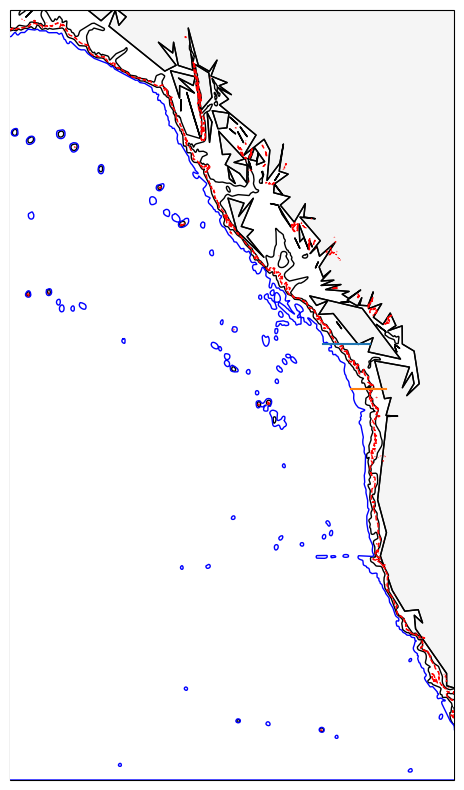

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))

elev = ds.elevation
mask = ~((ds.lon > -124.5) & (ds.lon < -122.0) & (ds.lat > 47.5) & (ds.lat < 49.5))
elev_masked = elev.where(mask)

# Add custom 500m isobath from GEBCO
cs = ax.contour(ds.lon, ds.lat, elev_masked, levels=[-500],
                colors='r', linewidths=1, transform=crs.PlateCarree(), zorder=5)
#ax.clabel(cs, fmt='%d m', fontsize=8)

# offshore cuttoff 
# y=np.linspace(42,52,100)
# x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
# ax.plot(x,y, transform=crs.PlateCarree(),zorder=7, c='r')

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [11]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/ghoeven/MOAD/Data/ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.geometry.union_all())

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [12]:
# can we do the same for data between the 2000m and 200m isobar? call it "slope" data instead of "shelf"

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/ghoeven/MOAD/Data/ne_10m_bathymetry_K_200.shp")

# Filter for the 2000 m contour polygons
contour_200m = bathymetry[bathymetry['depth'] == 200]

contour_200m = contour_200m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs_200 = obs_gdf[obs_gdf.location_type=='shelf'] # using the shelf data only so that we don't group the offshore data in with the slope data
# obs_200 = obs_200.to_crs(contour_200m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_200['is_slope'] = obs_200.within(contour_200m.geometry.union_all())

# Apply classification based on the result of spatial join
obs_200['location_type'] = obs_200['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

/home/ghoeven/conda_envs/analysis-griffon/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [13]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_200['location_type']

/tmp/ipykernel_768295/3885089491.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs.location[obs.location=='shelf'] = obs_200['location_type']
/tmp/ipykernel_768295/3885089491.py:2: SettingWithCopyWarning: 
A value is trying to be set o

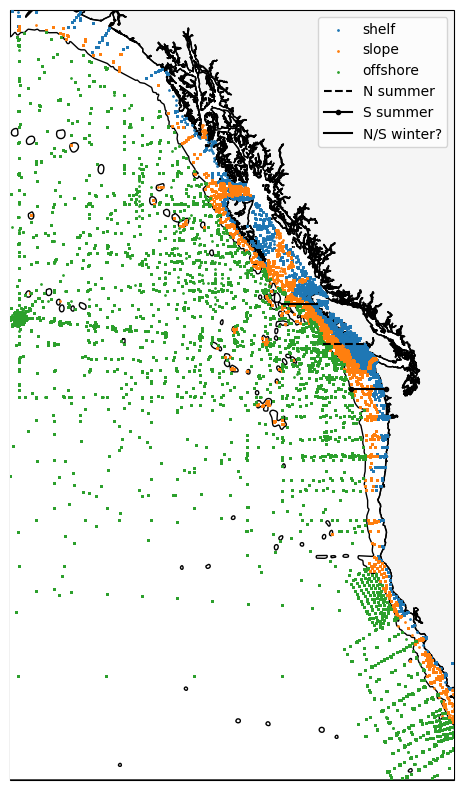

In [14]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

#cuttoffs
ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

In [15]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so get month from the time

obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

In [16]:
# Seperating Shelf current 
obs['current'] = ""

# Adding all points on the shelf to our overall shelf current
obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'
# Removing shelf current rows that do not fulfill our minimum salinity requirements (river water)
obs = obs[~((obs['current'] == 'Shelf_Current') & (obs['salinity (g kg-1)'] < 31.5))]

/tmp/ipykernel_768295/4205603307.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'
/tmp/ipykernel_768295/4205603307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

In [17]:
# Seperating CUC
densMin = 26.5
densMax = 26.6
depthMin = 175
depthMax = 275
obs['salinity (psu)'] = unit_conversions.teos_psu(obs['salinity (g kg-1)'])
obs['density (kg m-3)'] = psu_tools.calculate_density(obs['temperature (degC)'], obs['salinity (psu)'])-1000

# Selecting data that is on the 26.5-26.6 isopycnal and where a current is over the continental slope
mask = ((obs['density (kg m-3)'] >= densMin) # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013
        & (obs['density (kg m-3)'] <= densMax) # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013
        & (obs['depth (m)'] <= depthMax) # from Thomson & Krassovski 2010
        & (obs['depth (m)'] >= depthMin) # from Thomson & Krassovski 2010
        & (obs['latitude (degrees_north)'] < 50) # from Meinvielle & Johnson 2013
        & (obs['latitude (degrees_north)'] > 25) # from Meinvielle & Johnson 2013
        & (obs['location'] == 'slope')) # from Meinvielle & Johnson 2013
obs.loc[mask, 'current'] = 'CUC'
print(obs[mask][['depth (m)', 'density (kg m-3)', 'location']].head())
cuc_obs = obs[obs['current'] == 'CUC']
print(cuc_obs[~(cuc_obs['location'] == 'slope')])

       depth (m)  density (kg m-3) location
85990      175.0         26.568594    slope
85991      176.0         26.576781    slope
85992      181.0         26.578257    slope
85993      182.0         26.594285    slope
85994      183.0         26.594309    slope
Empty DataFrame
Columns: [Unnamed: 0, time, longitude (degrees_east), latitude (degrees_north), depth (m), pressure (dbar), temperature (degC), salinity (g kg-1), DO (umol kg-1), NO3 (uM), NO2 (uM), NH4 (uM), PO4 (uM), SiO4 (uM), Chl (mg m-3), TA (uM), DIC (uM), Carbonate, Aragonite, Calcite, Cd (nmol kg-1), Co (nmol kg-1), Cu (nmol kg-1), Fe (nmol kg-1), Mn (nmol kg-1), Ni (nmol kg-1), Zn (nmol kg-1), source, Nstar (umol kg-1), spice, current, geometry, location, month, salinity (psu), density (kg m-3)]
Index: []

[0 rows x 36 columns]


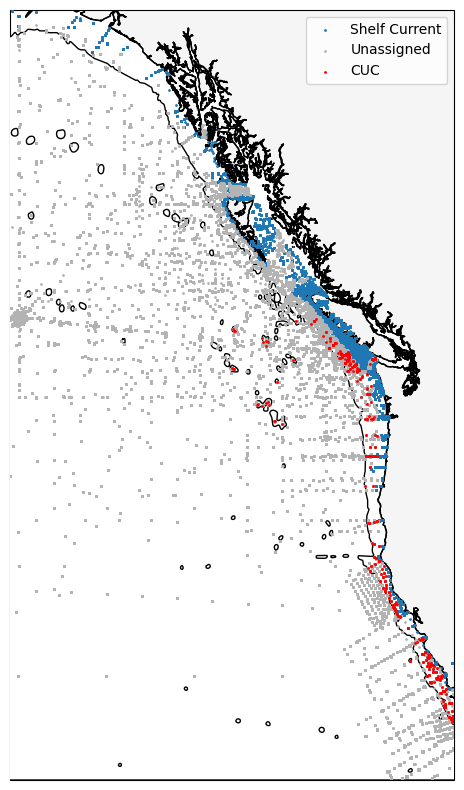

In [18]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=5,label='CUC')


#cuttoffs
# ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
# ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
# ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

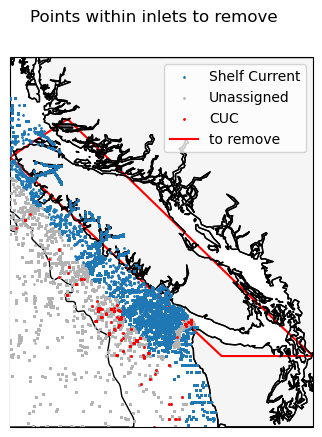

In [39]:
xlim, ylim = [-128.5, -122.2], [47, 52]

fig, ax = plt.subplots(1,1, subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=5,label='CUC')

poly = np.array([[-128.5, 50.7],
         [-127.3, 51.2],
         [-122.2, 48],
         [-124.1, 48],
         [-128.5, 50.7]])
ax.plot(poly[:,0], poly[:,1], c='r', transform=crs.PlateCarree(), label='to remove')

#cuttoffs
# ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
# ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
# ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')
plt.suptitle('Points within inlets to remove')

ax.legend()

In [26]:
poly[:,1]

array([50., 51., 48., 48.])

In [20]:
obs_cuc = obs[obs["current"] == 'CUC']
obs_cuc

,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),NO3 (uM),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,current,geometry,location,month,salinity (psu),density (kg m-3)
85990,139261,1972-05-09 00:00:00+00:00,-126.68,48.63,175.0,176.566500,6.968328,34.074884,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.027551,CUC,POINT (-126.68 48.63),slope,5,33.914960,26.568594
85991,139262,1972-05-09 00:00:00+00:00,-126.68,48.63,176.0,177.575880,6.908342,34.074914,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.036337,CUC,POINT (-126.68 48.63),slope,5,33.914990,26.576781
85992,139263,1972-05-09 00:00:00+00:00,-126.68,48.63,181.0,182.622880,6.898345,34.075066,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.037692,CUC,POINT (-126.68 48.63),slope,5,33.915141,26.578257
85993,139264,1972-05-09 00:00:00+00:00,-126.68,48.63,182.0,183.632300,6.838359,34.085153,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.039219,CUC,POINT (-126.68 48.63),slope,5,33.925181,26.594285
85994,139265,1972-05-09 00:00:00+00:00,-126.68,48.63,183.0,184.641710,6.838359,34.085183,NaN,NaN,...,NaN,ios ctd profiles,NaN,-0.039197,CUC,POINT (-126.68 48.63),slope,5,33.925211,26.594309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178744,2587295,2023-05-03 00:00:00+00:00,-126.67,48.65,211.0,212.700000,7.012600,34.118870,90.400192,NaN,...,NaN,ios ctd profiles,NaN,0.010546,CUC,POINT (-126.67 48.65),slope,5,33.958740,26.597025
1178745,2587296,2023-05-03 00:00:00+00:00,-126.67,48.65,212.0,213.500000,7.018500,34.117729,91.051947,NaN,...,NaN,ios ctd profiles,NaN,0.010600,CUC,POINT (-126.67 48.65),slope,5,33.957605,26.595322
1178746,2587297,2023-05-03 00:00:00+00:00,-126.67,48.65,213.0,214.866667,7.017133,34.117471,91.413572,NaN,...,NaN,ios ctd profiles,NaN,0.010212,CUC,POINT (-126.67 48.65),slope,5,33.957347,26.595306
1178747,2587298,2023-05-03 00:00:00+00:00,-126.67,48.65,214.0,216.050000,7.004750,34.119185,91.050642,NaN,...,NaN,ios ctd profiles,NaN,0.009612,CUC,POINT (-126.67 48.65),slope,5,33.959053,26.598347


Text(0, 0.5, 'depth (m)')

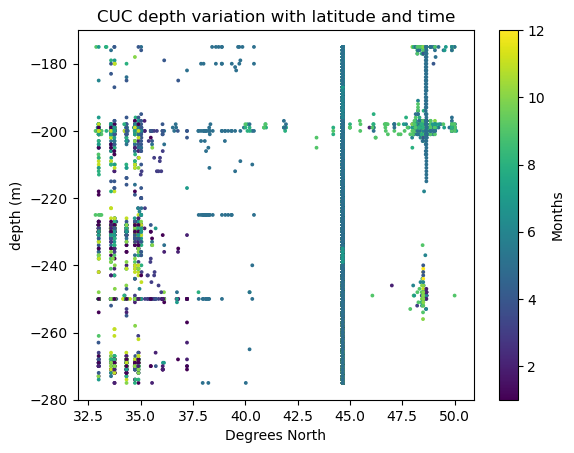

In [17]:


sc = plt.scatter(obs_cuc['latitude (degrees_north)'], -obs_cuc['depth (m)'], c=obs_cuc['month'], cmap='viridis', s=3, vmin=1, vmax=12)
plt.colorbar(sc, orientation='vertical', label='Months')
plt.title('CUC depth variation with latitude and time')
plt.xlabel('Degrees North')
plt.ylabel('depth (m)')
# sc = ax.scatter(lon0m, lat0m, transform=crs.PlateCarree(), c=chl0m, cmap='viridis', s=3, vmin=0, vmax=45)
# cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='Chlorophyll at Surface (mg m^-3)')

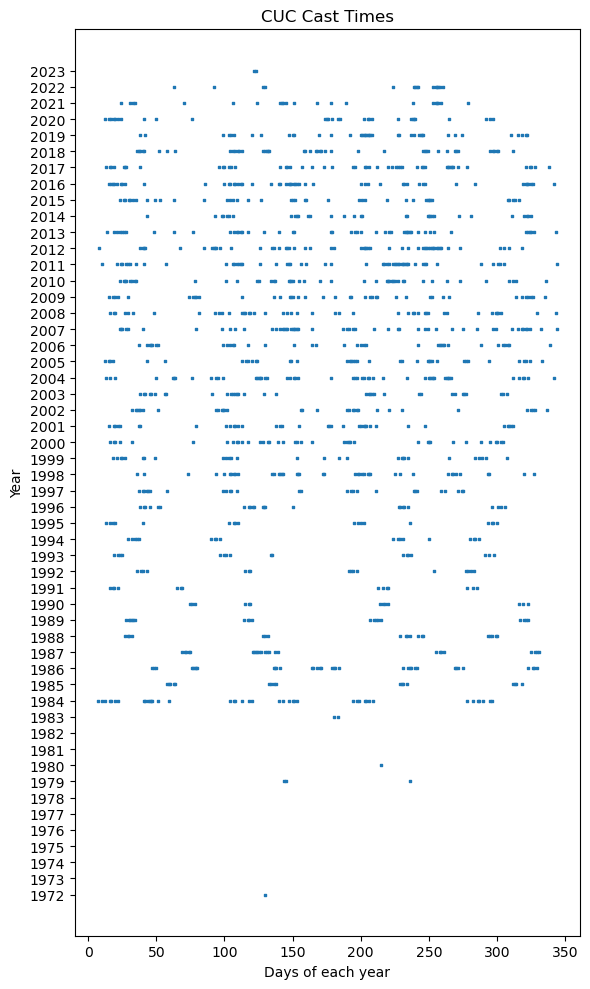

In [18]:
# plt.scatter(obs_cuc['time'], np.ones(len(obs_cuc)))

fig, ax = plt.subplots(figsize=(6, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2024))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

(125, 50) (125, 50) (125, 50)


/tmp/ipykernel_2593021/2381964807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc['cast_id'] = obs_cuc.groupby(['time', 'longitude (degrees_east)', 'latitude (degrees_north)']).ngroup()


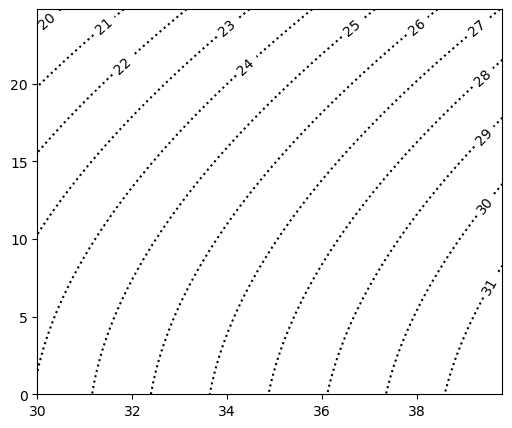

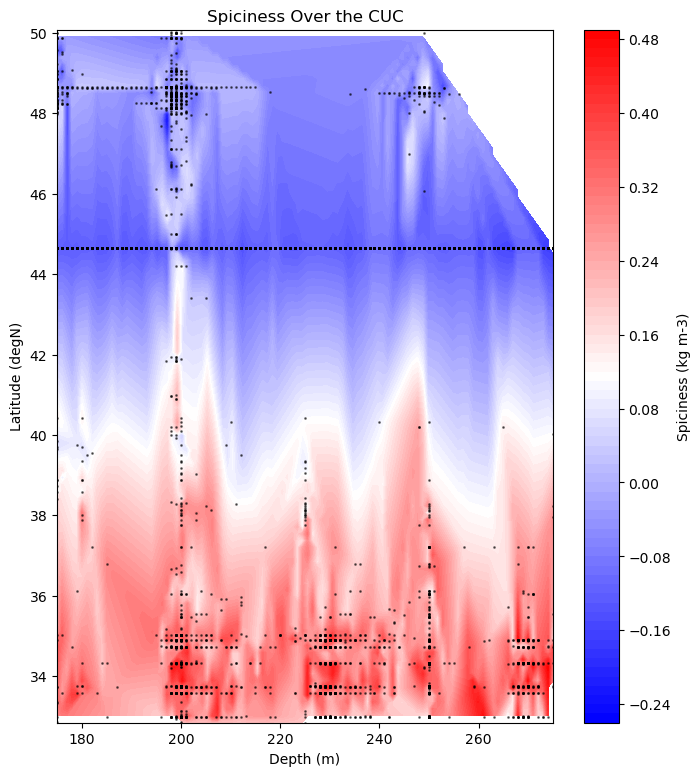

In [47]:
# Spiciness as a function of depth and latitude along CUC
x = obs_cuc['depth (m)'] 
y = obs_cuc['latitude (degrees_north)'] 
z = obs_cuc['spice']  # scalar field 

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method='linear')

# Make the contour plot
plt.figure(figsize=(8, 9))
cp = plt.contourf(xi, yi, zi, levels=80, cmap='bwr')
plt.colorbar(cp, label='Spiciness (kg m-3)')
plt.scatter(x, y, s=1, c='k', alpha=0.5)
plt.xlabel('Depth (m)')
plt.ylabel('Latitude (degN)')
plt.title('Spiciness Over the CUC')
plt.show()

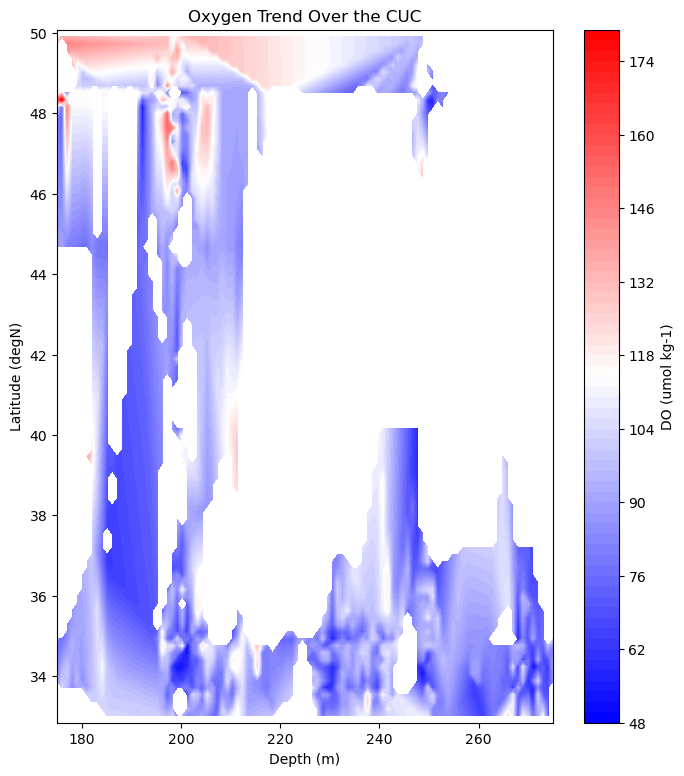

In [41]:
# DO as a function of depth and latitude along CUC
x = obs_cuc['depth (m)'] 
y = obs_cuc['latitude (degrees_north)'] 
z = obs_cuc['DO (umol kg-1)']  # scalar field 

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method='linear')

# Make the contour plot
plt.figure(figsize=(8, 9))
cp = plt.contourf(xi, yi, zi, levels=80, cmap='bwr')
plt.colorbar(cp, label='DO (umol kg-1)')
plt.xlabel('Depth (m)')
plt.ylabel('Latitude (degN)')
plt.title('Oxygen Trend Over the CUC')
plt.show()